# Noise Performance check of FACT Spare Electronics

Date: 02.11.2017

Setup: 
 * Single FAD & FPA pair in spare crate. 
 * No input to FPA. 
 * FAD label: FAD 06-24001-e1-0015 (FPGA fingerprint: 0x1550c02c3d09872, see below)
 * FPA label: ???

---

run explanation:

3 groups of three runs, taken with `drscalib.dim`:
 * drs-pedestal roi=1024, n_events=1000, trigger: FAD internal
 * drs-gain roi=1024, n_events=1000, trigger: FAD internal
 * drs-pedestal roi=1024, n_events=1000, trigger: FAD internal
  

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import numpy as np
import zfits
from tqdm import tqdm
import fact
from glob import glob

In [2]:
base_path = '/loc_data/raw/2017/11/02/'

In [3]:
for path in sorted(glob(base_path+'*.fits.fz')):
    f = zfits.FactFits(path)
    print('{path}: Nevts:{N}, roi:{R}, dacs:{D}'.format(
        path=path,
        N=f.rows,
        R=f.header()['NROI'],
        D=[f.header()['DAC{}'.format(i)] for i in range(1,4)]
    ))

/loc_data/raw/2017/11/02/20171102_001.fits.fz: Nevts:1000, roi:1024, dacs:[0, 0, 0]
/loc_data/raw/2017/11/02/20171102_002.fits.fz: Nevts:1000, roi:1024, dacs:[50000, 50000, 50000]
/loc_data/raw/2017/11/02/20171102_003.fits.fz: Nevts:1000, roi:1024, dacs:[0, 0, 0]
/loc_data/raw/2017/11/02/20171102_004.fits.fz: Nevts:1000, roi:1024, dacs:[0, 0, 0]
/loc_data/raw/2017/11/02/20171102_005.fits.fz: Nevts:1000, roi:1024, dacs:[50000, 50000, 50000]
/loc_data/raw/2017/11/02/20171102_006.fits.fz: Nevts:1000, roi:1024, dacs:[0, 0, 0]
/loc_data/raw/2017/11/02/20171102_007.fits.fz: Nevts:1000, roi:1024, dacs:[0, 0, 0]
/loc_data/raw/2017/11/02/20171102_008.fits.fz: Nevts:1000, roi:1024, dacs:[50000, 50000, 50000]
/loc_data/raw/2017/11/02/20171102_009.fits.fz: Nevts:1000, roi:1024, dacs:[0, 0, 0]


We start by looking at a normal drs-pedestal file. Normally our FACT++ software immediately calculates the so called "Baseline" for each cell of each pixel from this file. Actually this is also the case now, but since we have problems with noise, I wanted to look at the DRS calibration constants myself.

So instead of letting FACT++ calculate the Baseline I calculate it myself.

Normally such a file is 1000 x 1440 x 1024 x 2 byte = 3GB  in size and reading it entirely into memory in not a good idea (in all machines) ... the machine I am doing this analysis on has only 4GB memory.

But in this case, I only have 36 pixel -> ~100MB

So I start by reading the entire file into mem and also reading the stopcells.

In [4]:
raw = np.zeros((1000, 36, 1024), 'int16')
sc = np.zeros((1000, 36), 'int16')
f = zfits.FactFits(base_path+'20171102_001.fits.fz')
for event_id, d in tqdm(enumerate(f), total=f.rows):
    for chid in range(36):
        raw[event_id, chid] = d['Data'][chid]
        sc[event_id, chid] = d['StartCellData'][chid]

100%|██████████| 1000/1000 [00:12<00:00, 76.20it/s]


Now I want to see how noise the DRS calibration constants called "Baseline" for these 36 pixels are. So all I have to do is, rotate the raw data into the so called physical order and calculate the std-deviation.


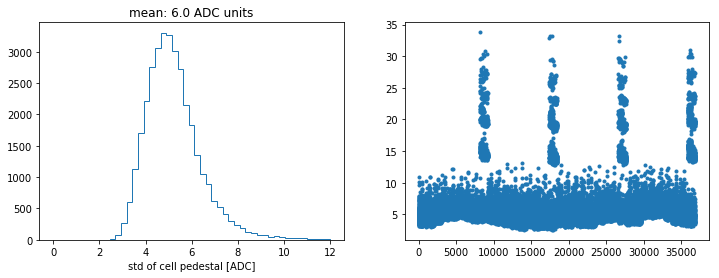

In [5]:
rolled = np.zeros_like(raw)
for event_id in range(len(raw)):
    for chid in range(36):
        rolled[event_id, chid] = np.roll(raw[event_id, chid], sc[event_id, chid])

std = rolled.std(axis = 0)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(std.flat, bins=np.linspace(0, 12, 50), histtype='step')
ax[0].set_xlabel('std of cell pedestal [ADC]')
ax[0].set_title('mean: {:.1f} ADC units'.format(std.mean()))

ax[1].plot(std.flat, '.');

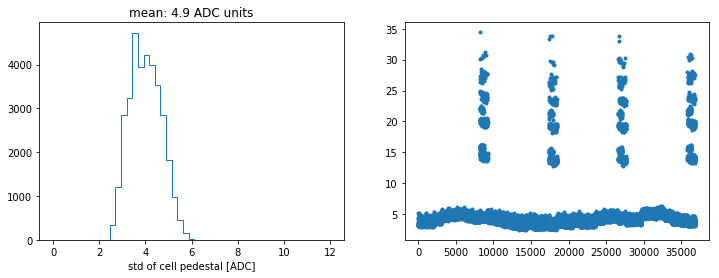

In [6]:
rolled_2 = np.zeros_like(raw, dtype='f4')
for event_id in range(len(raw)):
    for chid in range(36):
        x = raw[event_id, chid].copy().astype('f4')
        x[:20] = np.nan
        x[-20:] = np.nan
        rolled_2[event_id, chid] = np.roll(x, sc[event_id, chid])

std = np.nanstd(rolled_2, axis = 0)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(std.flat, bins=np.linspace(0, 12, 50), range=(0, 12), histtype='step')
ax[0].set_xlabel('std of cell pedestal [ADC]')
ax[0].set_title('mean: {:.1f} ADC units'.format(std.mean()))

ax[1].plot(std.flat, '.');

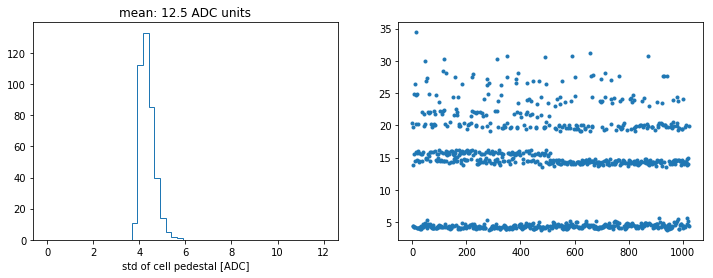

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(std[8], bins=np.linspace(0, 12, 50), range=(0, 12), histtype='step')
ax[0].set_xlabel('std of cell pedestal [ADC]')
ax[0].set_title('mean: {:.1f} ADC units'.format(std[8].mean()))

ax[1].plot(std[8], '.');

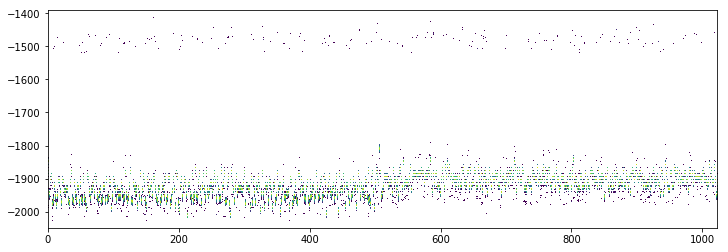

In [8]:
plt.figure(figsize=(12,4))
plt.hist2d(
    np.arange(1024).repeat(1000), 
    rolled[:,8,:].T.flatten(),
    bins=(1000, 1024),
    norm=LogNorm()
);

In [9]:
print('number of entries > -1600:', (rolled[:,8,:] > -1600).sum())

number of entries > -1600: 1000


number of entries > -1600: 1000


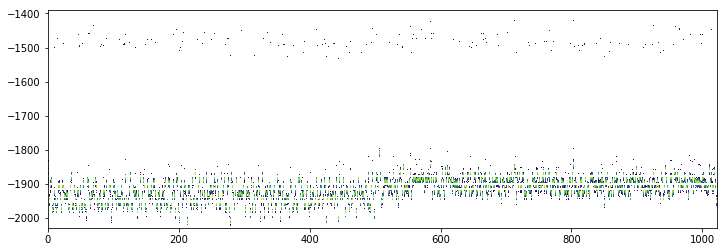

In [10]:
X = np.arange(1024).repeat(1000)
Y = rolled_2[:,8,:].T.flatten()


plt.figure(figsize=(12,4))
plt.hist2d(
    X[~np.isnan(Y)],
    Y[~np.isnan(Y)],
    bins=(1000, 1024),
    norm=LogNorm()
);

print('number of entries > -1600:', (Y[~np.isnan(Y)] > -1600).sum())

Aendert gar nix

Probieren wir mal mean und std aus CDF

In [11]:
M, S = np.zeros((36, 1024), 'f4'), np.zeros((36, 1024), 'f4')
for chid in range(36):
    for cell in range(1024):
        left, mid, right = np.nanpercentile(rolled_2[:, chid, cell], [50-34.1, 50, 50+34.1])
        M[chid, cell] = mid
        S[chid, cell] = (right - left) / 2

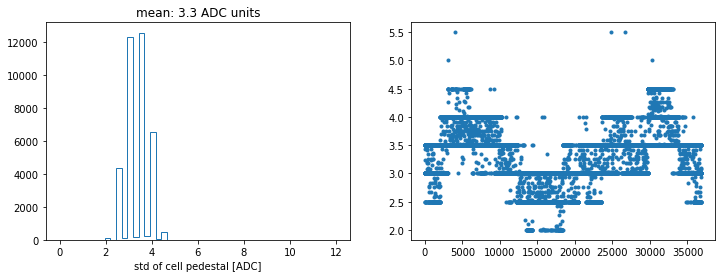

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(S.flat, bins=np.linspace(0, 12, 50), range=(0, 12), histtype='step')
ax[0].set_xlabel('std of cell pedestal [ADC]')
ax[0].set_title('mean: {:.1f} ADC units'.format(S.mean()))

ax[1].plot(S.flat, '.');

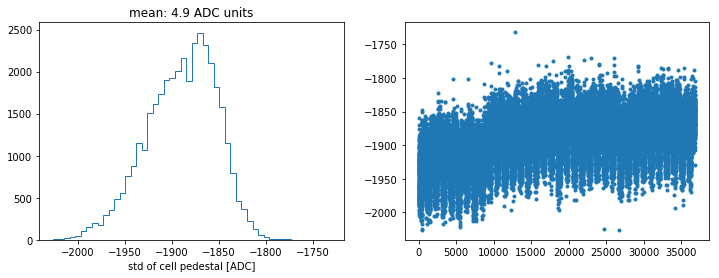

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(M.flat, bins=50, histtype='step')
ax[0].set_xlabel('std of cell pedestal [ADC]')
ax[0].set_title('mean: {:.1f} ADC units'.format(std.mean()))

ax[1].plot(M.flat, '.');

In [14]:
M, S = np.zeros((36, 1024), 'f4'), np.zeros((36, 1024), 'f4')
for chid in range(36):
    for cell in range(1024):
        left, mid, right = np.nanpercentile(rolled[:, chid, cell], [50-34.1, 50, 50+34.1])
        M[chid, cell] = mid
        S[chid, cell] = (right - left) / 2

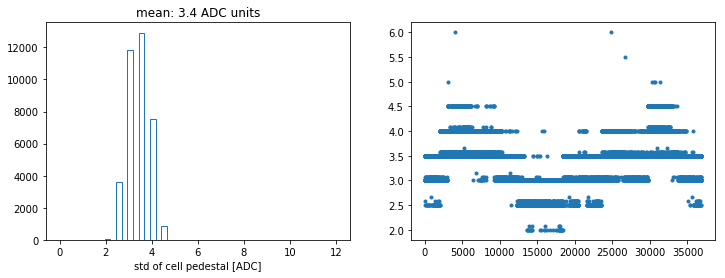

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(S.flat, bins=np.linspace(0, 12, 50), range=(0, 12), histtype='step')
ax[0].set_xlabel('std of cell pedestal [ADC]')
ax[0].set_title('mean: {:.1f} ADC units'.format(S.mean()))

ax[1].plot(S.flat, '.');

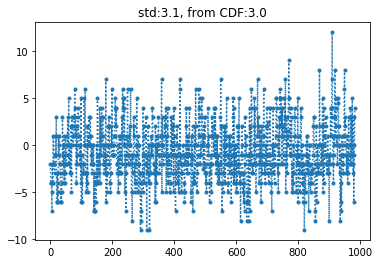

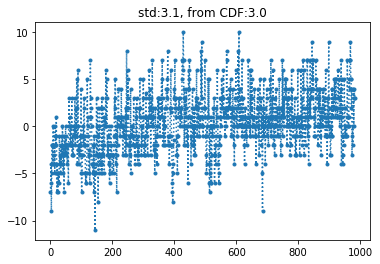

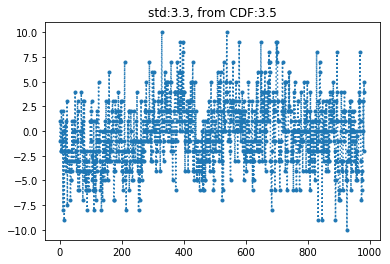

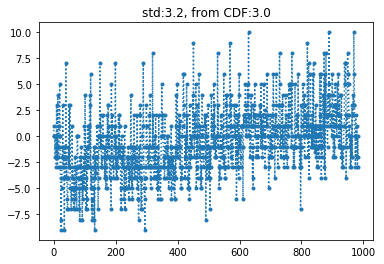

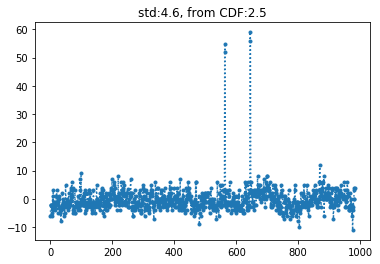

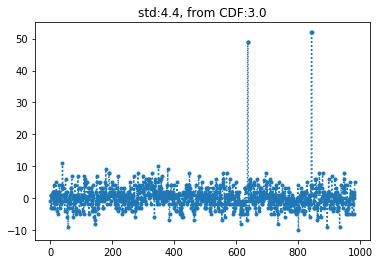

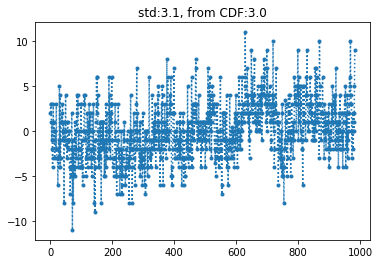

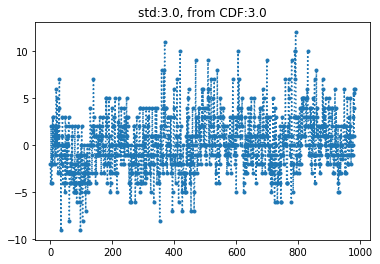

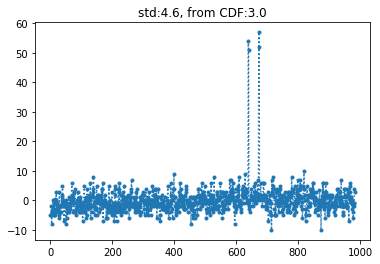

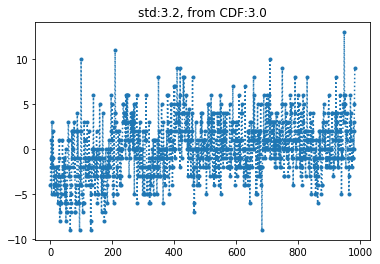

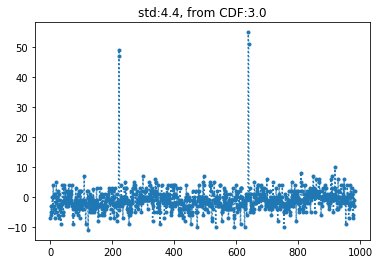

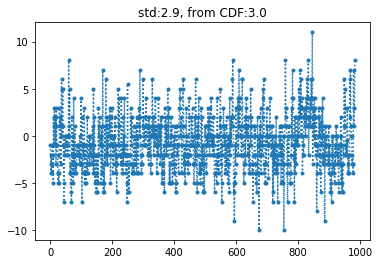

In [16]:
f2 = zfits.FactFits(base_path+"20171102_003.fits.fz")
MM = np.concatenate((M, M), axis=1)

for i, d in enumerate(f2):
    x = d['Data'][0, 20:-20]
    N = len(x)
    c = d['StartCellData'][0] + 20
    plt.figure()
    foo = x - MM[0, c:c+N]
    plt.plot(foo, '.:')
    left, right = np.percentile(foo, [50-34.1, 50+34.1])
    plt.title('std:{0:.1f}, from CDF:{1:.1f}'.format(foo.std(), (right-left)/2))
    
    if i > 10:
        break
